In [1]:
import os
os.chdir('/home/reggie/cosmo_learn')

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cosmo_learn.cosmo_learn import *
from astropy.cosmology import FlatwCDM

### One mock

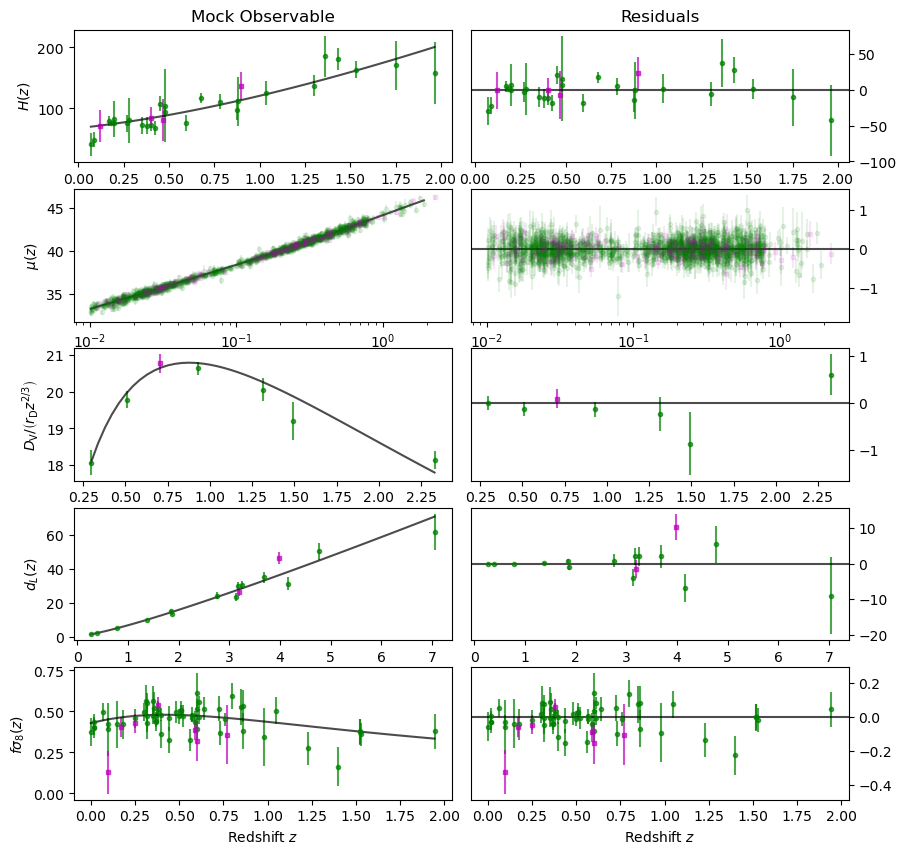

In [3]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, w0, s8 = 70, 0.3, -1, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, w0, s8 = 67.74, 0.3095, -0.997, 0.834
Ok0=0; wa=0
cosmo=FlatwCDM(H0=H0, Om0=Om0, w0=w0) # baseline astropy model

my_cosmo_learn=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
mock_keys=['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', \
           'BrightSirens', 'RedshiftSpaceDistorsions']
my_cosmo_learn.make_mock(mock_keys=mock_keys)

# fig, ax=my_cosmo_learn.show_mocks(show_input=True) # only mocks, no residuals
fig, ax=my_cosmo_learn.show_mocks_and_residuals(show_input=True, label_train=None, label_test=None)
fig.subplots_adjust(wspace=0.05)
plt.show()

### Multiple mocks, fixed random seed

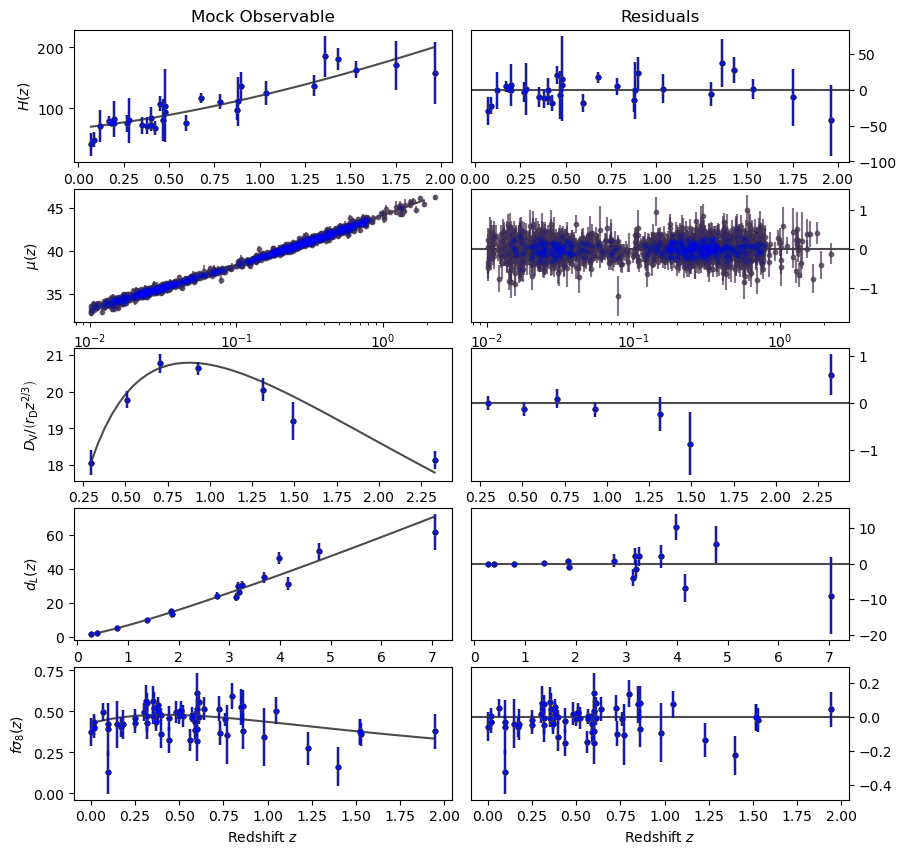

In [4]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, w0, s8 = 70, 0.3, -1, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, w0, s8 = 67.74, 0.3095, -0.997, 0.834
Ok0=0; wa=0
cosmo=FlatwCDM(H0=H0, Om0=Om0, w0=w0) # baseline astropy model

my_cosmo_learn=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
mock_keys=['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', \
           'BrightSirens', 'RedshiftSpaceDistorsions']
my_cosmo_learn.make_mock(mock_keys=mock_keys)

# fig, ax=my_cosmo_learn.show_mocks(show_input=True) # only mocks, no residuals
fig, ax=my_cosmo_learn.show_mocks_and_residuals(show_input=True, fmt_train='go', fmt_test='go')
fig.subplots_adjust(wspace=0.05)

# loop with fixed random seed
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for rs in range(10):
    my_cosmo_learn_rs=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
    my_cosmo_learn_rs.make_mock(mock_keys=mock_keys)
    color = colors[rs % len(colors)]
    my_cosmo_learn_rs.show_mocks_and_residuals(ax=ax, fmt_train=f'{color}o', fmt_test=f'{color}o')
plt.show()

### Multiple mocks, changing random seed

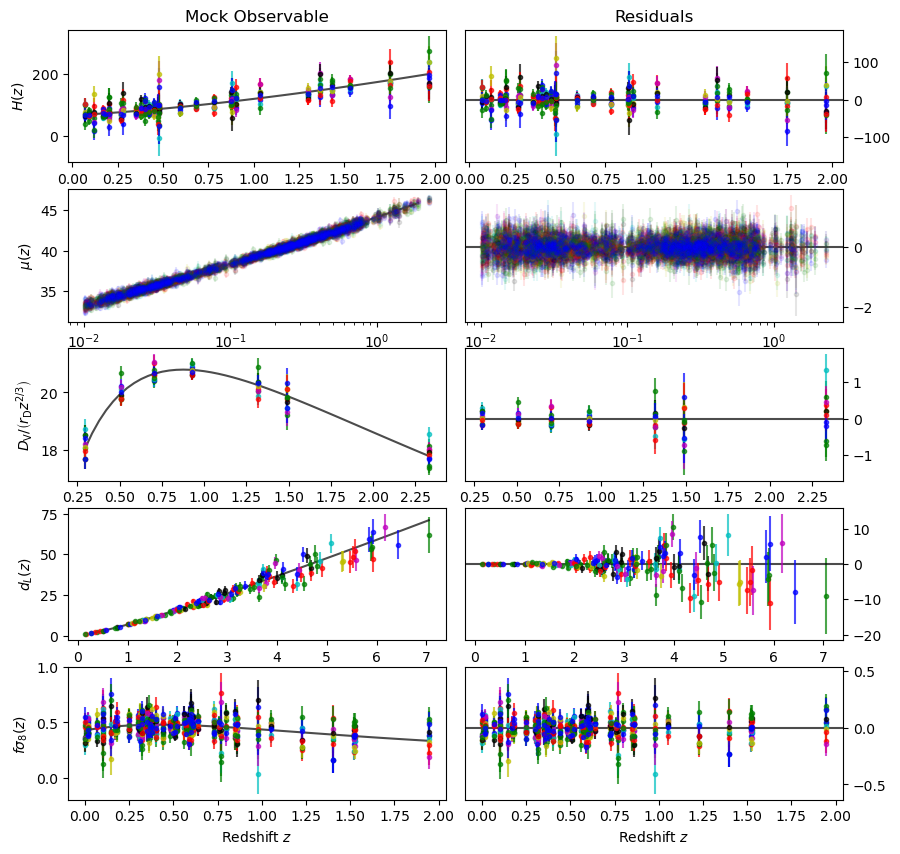

In [5]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, w0, s8 = 70, 0.3, -1, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, w0, s8 = 67.74, 0.3095, -0.997, 0.834
Ok0=0; wa=0
cosmo=FlatwCDM(H0=H0, Om0=Om0, w0=w0) # baseline astropy model

my_cosmo_learn=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
mock_keys=['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', \
           'BrightSirens', 'RedshiftSpaceDistorsions']
my_cosmo_learn.make_mock(mock_keys=mock_keys)

# fig, ax=my_cosmo_learn.show_mocks(show_input=True) # only mocks, no residuals
fig, ax=my_cosmo_learn.show_mocks_and_residuals(show_input=True, fmt_train='go', fmt_test='go')
fig.subplots_adjust(wspace=0.05)

# loop with changing seed
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for rs in range(10):
    my_cosmo_learn_rs=CosmoLearn([H0, Om0, w0, s8], seed=rs)
    my_cosmo_learn_rs.make_mock(mock_keys=mock_keys)
    color = colors[rs % len(colors)]
    my_cosmo_learn_rs.show_mocks_and_residuals(ax=ax, fmt_train=f'{color}o', fmt_test=f'{color}o')
plt.show()

### One Mock: Train + Test

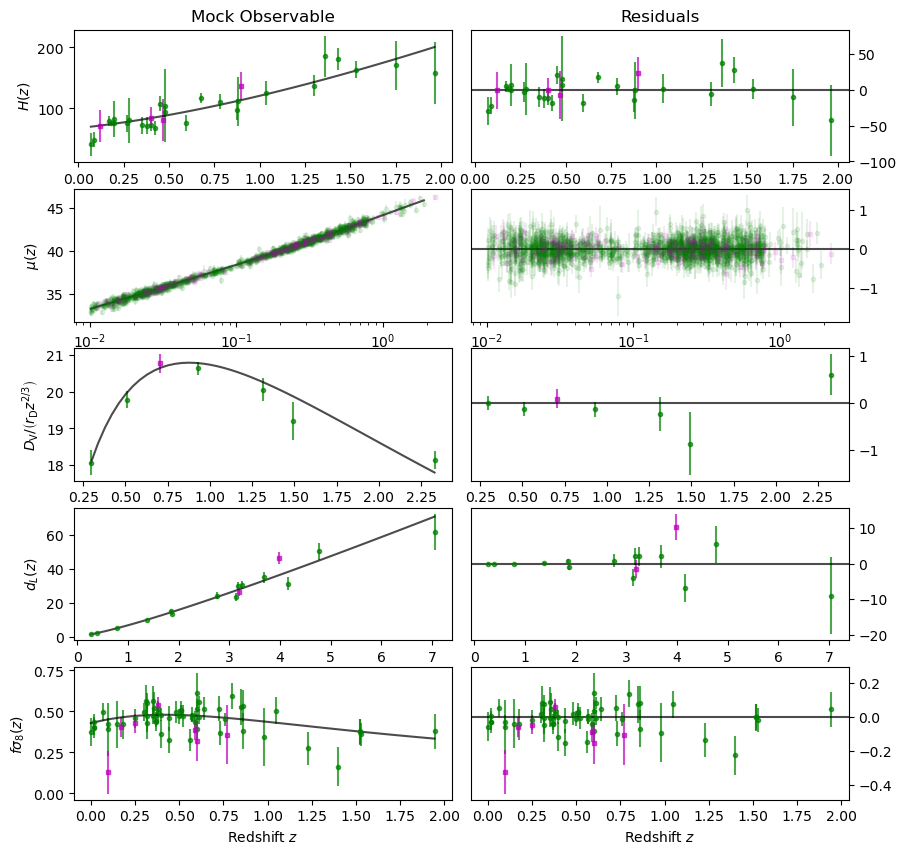

In [27]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, w0, s8 = 70, 0.3, -1, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, w0, s8 = 67.74, 0.3095, -0.997, 0.834
Ok0=0; wa=0
cosmo=FlatwCDM(H0=H0, Om0=Om0, w0=w0) # baseline astropy model

my_cosmo_learn=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
mock_keys=['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', \
           'BrightSirens', 'RedshiftSpaceDistorsions']
my_cosmo_learn.make_mock(mock_keys=mock_keys)

# fig, ax=my_cosmo_learn.show_mocks(show_input=True) # only mocks, no residuals
fig, ax=my_cosmo_learn.show_mocks_and_residuals(show_input=True, label_train=None, label_test=None)
fig.subplots_adjust(wspace=0.05)
plt.show()

### GP/BRR Reconstruction

In [2]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, w0, s8 = 70, 0.3, -1, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, w0, s8 = 67.74, 0.3095, -0.997, 0.834
Ok0=0; wa=0
cosmo=FlatwCDM(H0=H0, Om0=Om0, w0=w0) # baseline astropy model

my_cosmo_learn=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
mock_keys=['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', \
           'BrightSirens', 'RedshiftSpaceDistorsions']
# mock_keys=['CosmicChronometers', \
#            'BrightSirens', 'RedshiftSpaceDistorsions']

my_cosmo_learn.make_mock(mock_keys=mock_keys)
my_cosmo_learn.train_gp()
my_cosmo_learn.train_brr()

/Users/reginaldchristianbernardo/miniconda3/envs/cosmo/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/reginaldchristianbernardo/miniconda3/envs/cosmo/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/reginaldchristianbernardo/miniconda3/envs/cosmo/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a

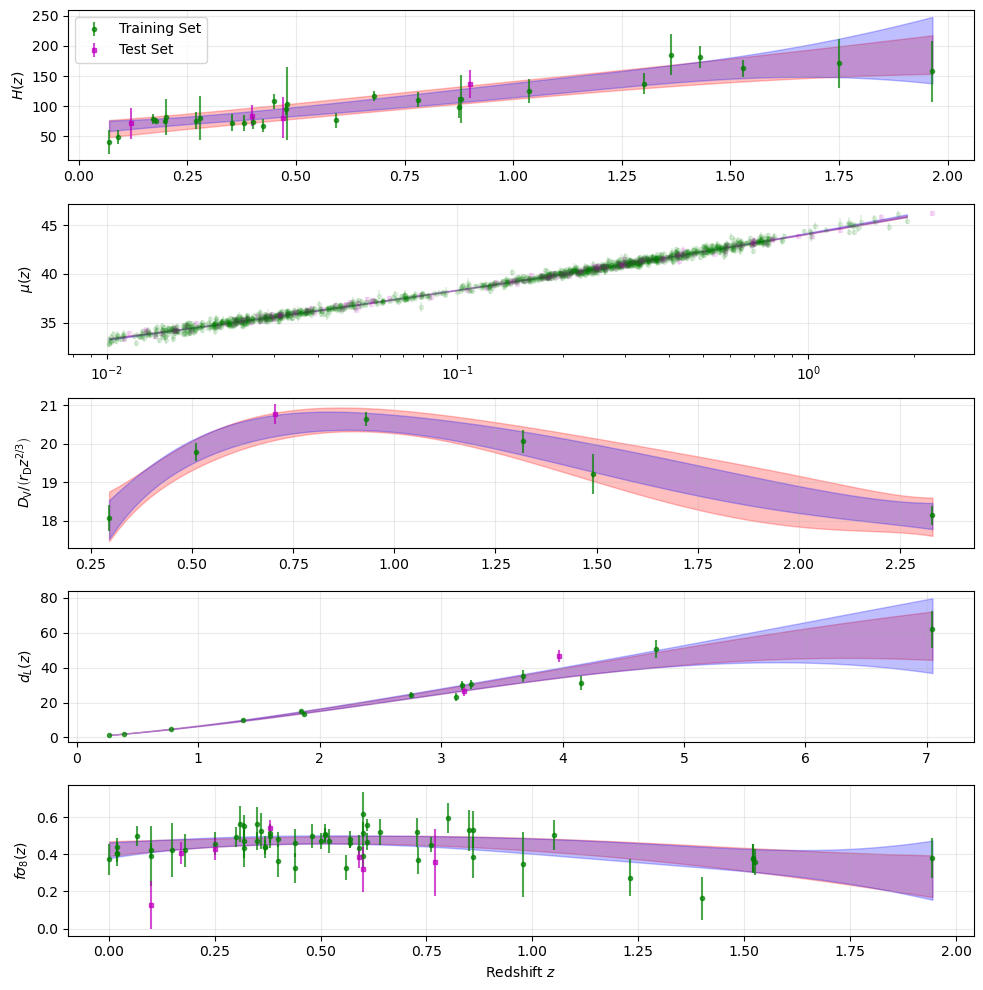

In [20]:
fig, ax=my_cosmo_learn.show_mocks(show_input=False)
n_sigma_rec=2
n_recz=100
for i, key in enumerate(my_cosmo_learn.mock_data.keys()):
    x_train=my_cosmo_learn.mock_data[key]['train']['x']
    if key=='SuperNovae':
        x_rec=np.linspace(np.log10(min(x_train)), np.log10(max(x_train)), n_recz)
    else:
        x_rec=np.linspace(min(x_train), max(x_train), n_recz)

    # gp reconstructions
    gp_cosmo=my_cosmo_learn.GP_dict[key]
    func_mean, func_err = gp_cosmo.predict(x_rec.reshape(-1, 1), return_std=True)
    color='red'
    if key!='BaryonAcousticOscillations':
        if key != 'SuperNovae':
            ax[i].fill_between(x_rec, func_mean-n_sigma_rec*func_err, func_mean+n_sigma_rec*func_err, \
                               facecolor=color, edgecolor=color, alpha=0.25)
        if key == 'SuperNovae':
            ax[i].fill_between(10**x_rec, func_mean-n_sigma_rec*func_err, func_mean+n_sigma_rec*func_err, \
                               facecolor=color, edgecolor=color, alpha=0.25)
    if key=='BaryonAcousticOscillations':
        ax[i].fill_between(x_rec, \
                           (func_mean-n_sigma_rec*func_err)/(x_rec**(2/3)), \
                           (func_mean+n_sigma_rec*func_err)/(x_rec**(2/3)), \
                           facecolor=color, edgecolor=color, alpha=0.25)
        
    # brr reconstructions
    brr_cosmo=my_cosmo_learn.BRR_dict[key]
    _, func_mean, func_var = brr_cosmo.predict(x_rec).values()
    func_err = np.sqrt(func_var)
    color='blue'
    if key!='BaryonAcousticOscillations':
        if key != 'SuperNovae':
            ax[i].fill_between(x_rec, func_mean-n_sigma_rec*func_err, func_mean+n_sigma_rec*func_err, \
                               facecolor=color, edgecolor=color, alpha=0.25)
        if key == 'SuperNovae':
            ax[i].fill_between(10**x_rec, func_mean-n_sigma_rec*func_err, func_mean+n_sigma_rec*func_err, \
                               facecolor=color, edgecolor=color, alpha=0.25)
    if key=='BaryonAcousticOscillations':
        ax[i].fill_between(x_rec, \
                           (func_mean-n_sigma_rec*func_err)/(x_rec**(2/3)), \
                           (func_mean+n_sigma_rec*func_err)/(x_rec**(2/3)), \
                           facecolor=color, edgecolor=color, alpha=0.25)

[ax[i].grid(True, alpha=0.25) for i in range(len(my_cosmo_learn.mock_data.keys()))]
ax[0].legend(loc='upper left', prop={'size': 10})
fig.tight_layout()
plt.show()

### ANN

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

2024-12-04 19:23:47.701476: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
ann_model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[1]),
                                 tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2()),
                                 tf.keras.layers.Dense(2),])
ann_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss=tf.keras.losses.MeanSquaredError(),)
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
 dense_1 (Dense)             (None, 100)               200       
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 404
Trainable params: 404
Non-trainable params: 0
_________________________________________________________________


2024-12-04 19:23:49.237875: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
# ann_model = tf.keras.Sequential([Dense(12, activation='relu', input_shape=[1]),
#                                  Dropout(0.1), Dense(4, activation='relu'),
#                                  Dropout(0.1), Dense(2, activation='relu')])

# optimizer = Adam(learning_rate=0.00008)
# ann_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae', 'mape'])
# ann_model.summary()

In [ ]:
# key='CosmicChronometers'
# # key='SuperNovae'
# # key='BaryonAcousticOscillations'
# # key='BrightSirens'
# # key='RedshiftSpaceDistorsions'
# my_cosmo_learn.mock_data.keys()
# train_data=my_cosmo_learn.mock_data[key]['train']
# x=train_data['x']; y=np.column_stack((train_data['y'], train_data['yerr']))

In [10]:
key='CosmicChronometers'
# key='SuperNovae'
# key='BaryonAcousticOscillations'
# key='BrightSirens'
# key='RedshiftSpaceDistorsions'
my_cosmo_learn.mock_data.keys()
train_data=my_cosmo_learn.mock_data[key]['train']
x=train_data['x']; y=np.column_stack((train_data['y'], train_data['yerr']))

# num_samples=len(x); n = int(0.9 * num_samples)
# print('Number of training samples:', n)
# print('Number of validation samples:', num_samples - n)
# print()

# x_train = x[:n]; y_train = y[:n]
# x_validation = x[n:]; y_validation= y[n:]

In [8]:
n_epochs=10000
# ann_history = ann_model.fit(x_train, y_train, epochs=n_epochs, \
#                             validation_data=(x_validation, y_validation), verbose=0)
ann_history = ann_model.fit(x, y, epochs=n_epochs, validation_split=0.9, verbose=0)

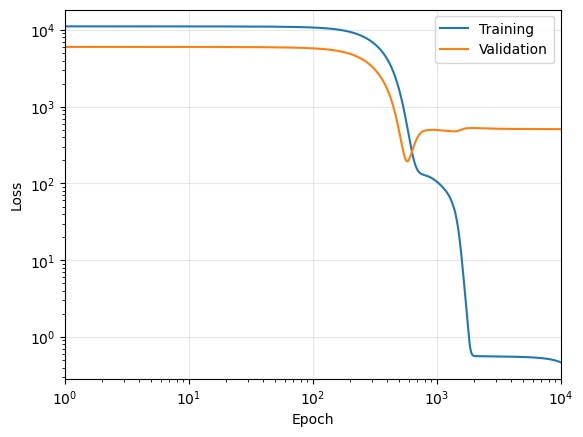

In [9]:
fig, ax=plt.subplots()
ax.plot(ann_history.history['loss'], label='Training')
ax.plot(ann_history.history['val_loss'], label='Validation')
ax.legend(loc='upper right', prop={'size': 10})
ax.set_xlim(1, n_epochs)
ax.set_yscale('log'); ax.set_xscale('log')
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
plt.show()

32/32 [==============================] - 0s 2ms/step


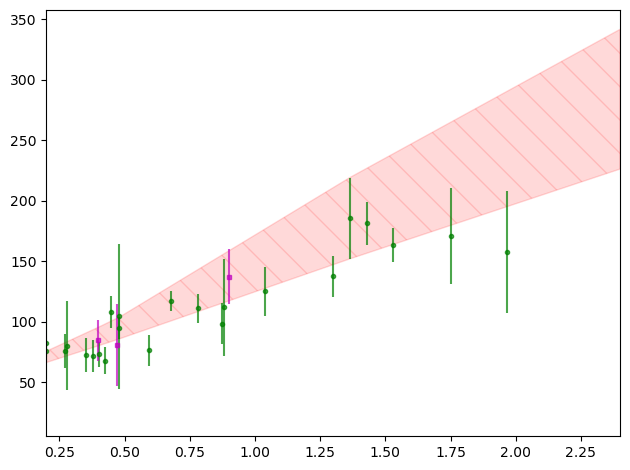

In [10]:
x_rec=np.linspace(0.2, 2.4, 1000)
# x_rec=np.logspace(-2.3, np.log10(2.5), 1000)
y_rec = ann_model.predict(x_rec)
ymean_rec = y_rec[:, 0]; yerr_rec = y_rec[:, 1]


fig, ax=plt.subplots()
key='CosmicChronometers'
# key='SuperNovae'
# key='BaryonAcousticOscillations'
# key='BrightSirens'
# key='RedshiftSpaceDistorsions'
my_cosmo_learn.plot_train_test_data(ax, key, alpha=0.7)
# my_cosmo_learn.plot_train_test_data(ax, key, fmt='.', alpha=0.15)
ax.fill_between(x_rec, ymean_rec-yerr_rec, ymean_rec+yerr_rec, \
                facecolor='red', edgecolor='red', alpha=0.15, hatch='\\', label='ANN')

# for bao below
# gw_cosmo.plot_train_test_data(ax, 'BaryonAcousticOscillations', fmt='.', alpha=0.7)
# ax.fill_between(x_rec, (ymean_rec-yerr_rec)/(x_rec**(2/3)), (ymean_rec+yerr_rec)/(x_rec**(2/3)), \
#                 facecolor='red', edgecolor='red', alpha=0.25, hatch='\\', label='ANN')

ax.set_xlim(min(x_rec), max(x_rec))
# ax.set_xscale('log')
# ax.set_ylabel(r'$H(z)$'); ax.set_xlabel(r'Redshift $z$')
# ax.legend(loc='upper left', prop={'size': 10})
fig.tight_layout()
plt.show()

### Inference MCMC and GA

In [21]:
# s8=0.834+/-0.016 (Planck); s8=0.745+/-0.039 (KiDS-450); see https://arxiv.org/abs/2008.11285
# H0, Om0, w0, s8 = 70, 0.3, -1, 0.8

# desi1 Flat wCDM https://arxiv.org/pdf/2404.03002 + planck s8
H0, Om0, w0, s8 = 67.74, 0.3095, -0.997, 0.834
Ok0=0; wa=0
cosmo=FlatwCDM(H0=H0, Om0=Om0, w0=w0) # baseline astropy model

my_cosmo_learn=CosmoLearn([H0, Om0, w0, s8], seed=14000605)
mock_keys=['CosmicChronometers', 'SuperNovae', 'BaryonAcousticOscillations', \
           'BrightSirens', 'RedshiftSpaceDistorsions']
# mock_keys=['CosmicChronometers', 'SuperNovae', 'BrightSirens', 'RedshiftSpaceDistorsions']
my_cosmo_learn.make_mock(mock_keys=mock_keys)

In [22]:
prior_dict={'H0_min': 0, 'H0_max': 100, 'Om0_min': 0, 'Om0_max': 1, \
            'w0_min': -10, 'w0_max': 10, 's8_min': 0.2, 's8_max': 1.5}
rd_fid_prior={'mu': 147.46, 'sigma': 0.28}
llprob=lambda x: my_cosmo_learn.llprob_wcdm(x, prior_dict=prior_dict, rd_fid_prior=rd_fid_prior)

p0=[70, 0.3, -1, 0.8, 147]
nwalkers=15; dres=[0.05, 0.005, 0.01, 0.01, 0.005]; nburn=100; nmcmc=2000
mcmc_samples=my_cosmo_learn.get_mcmc_samples(nwalkers, dres, llprob, p0, nburn=nburn, nmcmc=nmcmc)

Optimizing initial position...
... At [ 68.05074619   0.31509122  -1.04593345   0.82952935 147.54150534]
Running MCMC...


100%|██████████| 2000/2000 [01:01<00:00, 32.58it/s]

Done.
Mean acceptance fraction: 0.5556333333333333
Total time: 64.56522607803345
MCMC result:
    x[0] = 68.04236862603886 + 0.2763127747788445 - 0.27574493199317374
    x[1] = 0.31689009361390674 + 0.013212725318238583 - 0.014291905559369988
    x[2] = -1.0510698749845073 + 0.05880772992581984 - 0.06073335587883433
    x[3] = 0.8295575787562808 + 0.01571781735468525 - 0.015539230981304386
    x[4] = 147.5492912202857 + 0.2604183755964584 - 0.3010985025375419


In [23]:
prior_ga=[[prior_dict['H0_min'], prior_dict['H0_max']], [prior_dict['Om0_min'], prior_dict['Om0_max']], \
          [prior_dict['w0_min'], prior_dict['w0_max']], [prior_dict['s8_min'], prior_dict['s8_max']], \
          [rd_fid_prior['mu']-20*rd_fid_prior['sigma'], rd_fid_prior['mu']+20*rd_fid_prior['sigma']]]
fitness_func=lambda x: -2*my_cosmo_learn.llprob_wcdm(x, prior_dict=prior_dict, rd_fid_prior=rd_fid_prior)

ga_params={'max_num_iteration': 1000, 'population_size': 50, 'mutation_probability': 0.3, \
           'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, \
           'crossover_type':'uniform', 'max_iteration_without_improv': None}
gaFisher_samples=my_cosmo_learn.get_gaFisher_samples(fitness_func, prior_ga, ga_params=ga_params, \
                                                     llprob=llprob, nsamples=(nmcmc-nburn)*nwalkers)

|||||||||||||_____________________________________ 26.7% GA is running...

/Users/reginaldchristianbernardo/miniconda3/envs/cosmo/lib/python3.11/site-packages/geneticalgorithm/geneticalgorithm.py:353: RuntimeWarning: invalid value encountered in subtract
  normobj=maxnorm-normobj+1


 The best solution found:                                                                           
 [ 68.20728356   0.34185742  -1.16809948   0.83345977 147.47927643]

 Objective function:
 1507.0785643196393

GA-Fisher result:
    x[0] = 68.21072917170261 + 0.29822450765851727 - 0.3025812018466638
    x[1] = 0.342001159133124 + 0.01344394145423422 - 0.01355761746530304
    x[2] = -1.168489095740218 + 0.07324267154507735 - 0.07378875237763416
    x[3] = 0.8336753377319543 + 0.015320577198572605 - 0.01537609547265606
    x[4] = 147.4771281078335 + 0.2749177031596446 - 0.2716949921821197


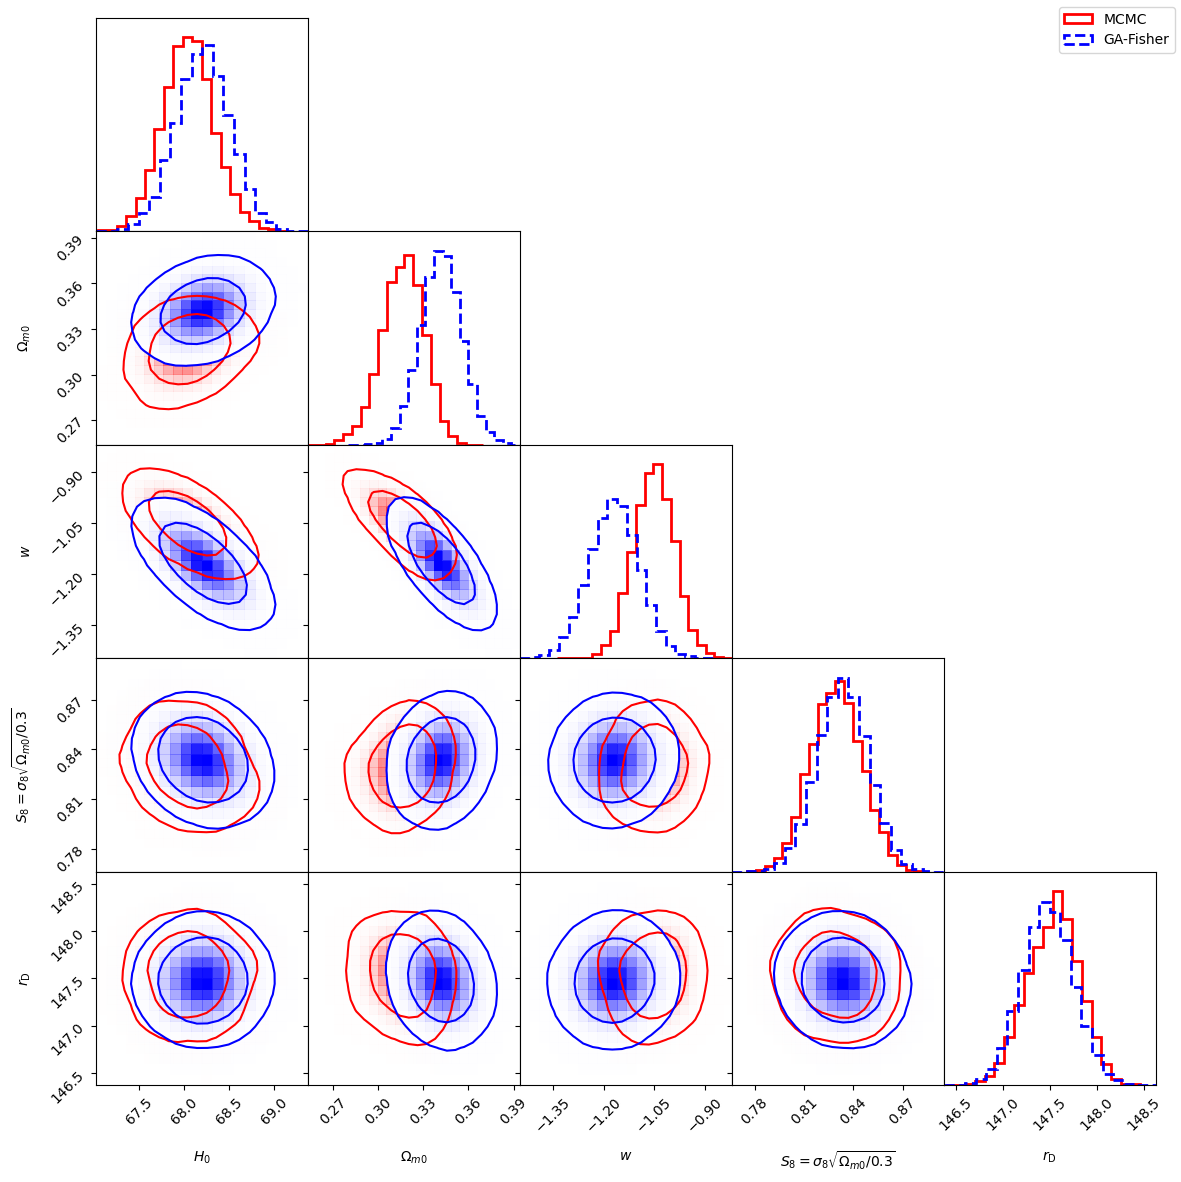

In [28]:
labels = [r'$H_0$', r'$\Omega_{m0}$', r'$w$', r'$S_8=\sigma_8 \sqrt{\Omega_{m0}/0.3}$']
params_true = [67.74, 0.3095, -0.997, 0.834]
# params_true = [70, 0.3, -1, 0.8]

# corner_plot = add_corner(mcmc_samples[:,:4], labels, color='red', ls='-')
# add_corner(gaFisher_samples[:,:4], labels, fig=corner_plot, color='blue', ls='--', \
#            add_truth=params_true, truth_color='gray')

corner_plot = add_corner(mcmc_samples, labels+[r'$r_{\rm D}$'], color='red', ls='-')
add_corner(gaFisher_samples, labels+[r'$r_{\rm D}$'], fig=corner_plot, color='blue', ls='--')

legend_labels = ['MCMC', 'GA-Fisher']
corner_plot.legend(legend_labels, loc='upper right')
corner_plot.tight_layout(); corner_plot.subplots_adjust(hspace=0, wspace=0)
# corner_plot.savefig('figs/corner_name.pdf', bbox_inches='tight')
plt.show()

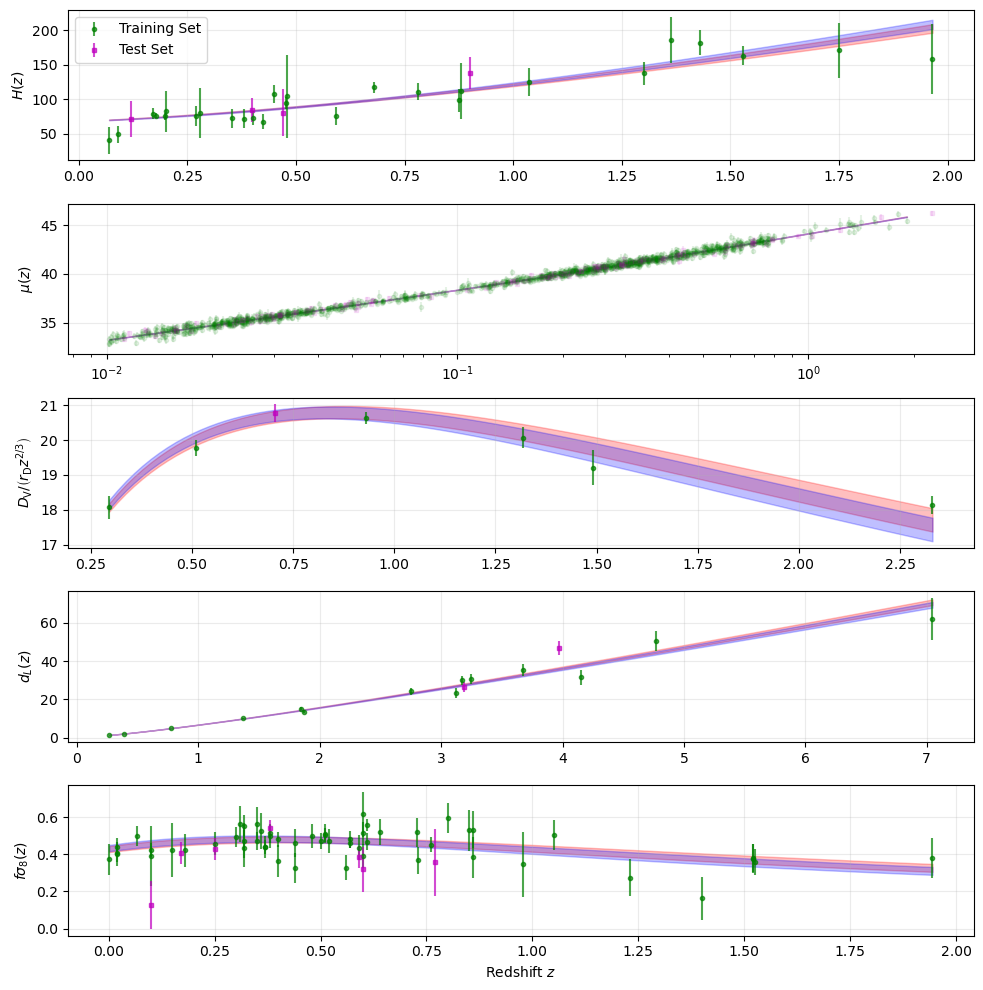

In [29]:
fig, ax=my_cosmo_learn.show_mocks(show_input=False)
n_sigma_rec=2
for i, key in enumerate(my_cosmo_learn.mock_data.keys()):
    cosmo_func=lambda x, p: my_cosmo_learn.cosmo_func_wcdm(x, p, key=key)
    x_train=my_cosmo_learn.mock_data[key]['train']['x']
    if key=='SuperNovae':
        x_rec=np.logspace(np.log10(min(x_train)), np.log10(max(x_train)), 100)
    else:
        x_rec=np.linspace(min(x_train), max(x_train), 100)

    # mcmc reconstructions
    my_samples=my_cosmo_learn.mcmc_samples
    x_rec, func_mean, func_err=mcreconstruct_function(cosmo_func, my_samples, x_rec=x_rec, nmc=1000)
    color='red'
    if key!='BaryonAcousticOscillations':
        ax[i].fill_between(x_rec, func_mean-n_sigma_rec*func_err, func_mean+n_sigma_rec*func_err, \
                           facecolor=color, edgecolor=color, alpha=0.25)
    if key=='BaryonAcousticOscillations':
        ax[i].fill_between(x_rec, \
                           (func_mean-n_sigma_rec*func_err)/(x_rec**(2/3)), \
                           (func_mean+n_sigma_rec*func_err)/(x_rec**(2/3)), \
                           facecolor=color, edgecolor=color, alpha=0.25)
        
    # # ga-Fisher reconstruction
    my_samples=my_cosmo_learn.gaFisher_samples
    x_rec, func_mean, func_err=mcreconstruct_function(cosmo_func, my_samples, x_rec=x_rec, nmc=1000)
    color='blue'
    if key!='BaryonAcousticOscillations':
        ax[i].fill_between(x_rec, func_mean-n_sigma_rec*func_err, func_mean+n_sigma_rec*func_err, \
                           facecolor=color, edgecolor=color, alpha=0.25)
    if key=='BaryonAcousticOscillations':
        ax[i].fill_between(x_rec, \
                           (func_mean-n_sigma_rec*func_err)/(x_rec**(2/3)), \
                           (func_mean+n_sigma_rec*func_err)/(x_rec**(2/3)), \
                           facecolor=color, edgecolor=color, alpha=0.25)

[ax[i].grid(True, alpha=0.25) for i in range(len(my_cosmo_learn.mock_data.keys()))]
ax[0].legend(loc='upper left', prop={'size': 10})
fig.tight_layout()
plt.show()